In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers import get_linear_schedule_with_warmup
from transformers import AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
import os
import zipfile
import nltk

# Installing the rouge package if needed
# Uncomment and run this cell if you don't have rouge installed
!pip install rouge-score
from rouge_score import rouge_scorer

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=6725cc8bc23087b8fea948a79d51349989ca03349f0019c1430b4252d49f0fce
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [4]:
from google.colab import files
import zipfile
import os

# Upload file
uploaded = files.upload()

# Get the filename
filename = list(uploaded.keys())[0]

Saving daily_mail_summarization_dataset.zip to daily_mail_summarization_dataset.zip


In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# 1. Load the Dataset from local zip file
# --------------------------------

# Extract the dataset from the local zip file
try:
    if not os.path.exists('data'):
        os.makedirs('data')

    # Path to your local zip file
    zip_path = 'daily_mail_summarization_dataset.zip'

    # Extract the data from zip
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')

    # Load the dataset with the known schema: url, article, highlights
    # Find the CSV file in the extracted directory
    csv_files = [f for f in os.listdir('data') if f.endswith('.csv')]
    if csv_files:
        csv_path = os.path.join('data', csv_files[0])
        df = pd.read_csv(csv_path)
        print(f"Dataset loaded successfully with {len(df)} examples")

        # Display sample
        print("\nSample data:")
        print(df.head(2))

        # Confirm columns match expected schema
        expected_cols = ['url', 'article', 'highlights']
        if all(col in df.columns for col in expected_cols):
            print("\nConfirmed CSV has the expected columns: url, article, highlights")
        else:
            print("\nWarning: CSV columns don't match expected schema. Found:", df.columns.tolist())
    else:
        print("No CSV file found in the extracted data directory.")

except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please check that your zip file is in the correct location and contains the expected CSV file.")

# Add an ID column if not present
if 'id' not in df.columns:
    df['id'] = range(len(df))

Dataset loaded successfully with 8176 examples

Sample data:
                                                 url  \
0  https://www.dailymail.co.uk/tvshowbiz/article-...   
1  https://www.dailymail.co.uk/tvshowbiz/article-...   

                                             article  \
0  Beyoncé showcases her incredible figure in plu...   
1  Radio 1 listeners in shock as sex noises are p...   

                                          highlights  
0  Beyoncé has shown off her flawless beauty in a...  
1  BBC Radio 1 listeners were left choking on the...  

Confirmed CSV has the expected columns: url, article, highlights



Missing values:
url            0
article       11
highlights     3
id             0
dtype: int64

Article statistics:
Average article length: 44.77 words
Max article length: 78 words
Min article length: 1 words

Highlight statistics:
Average highlight length: 23.05 words
Max highlight length: 53 words
Min highlight length: 1 words


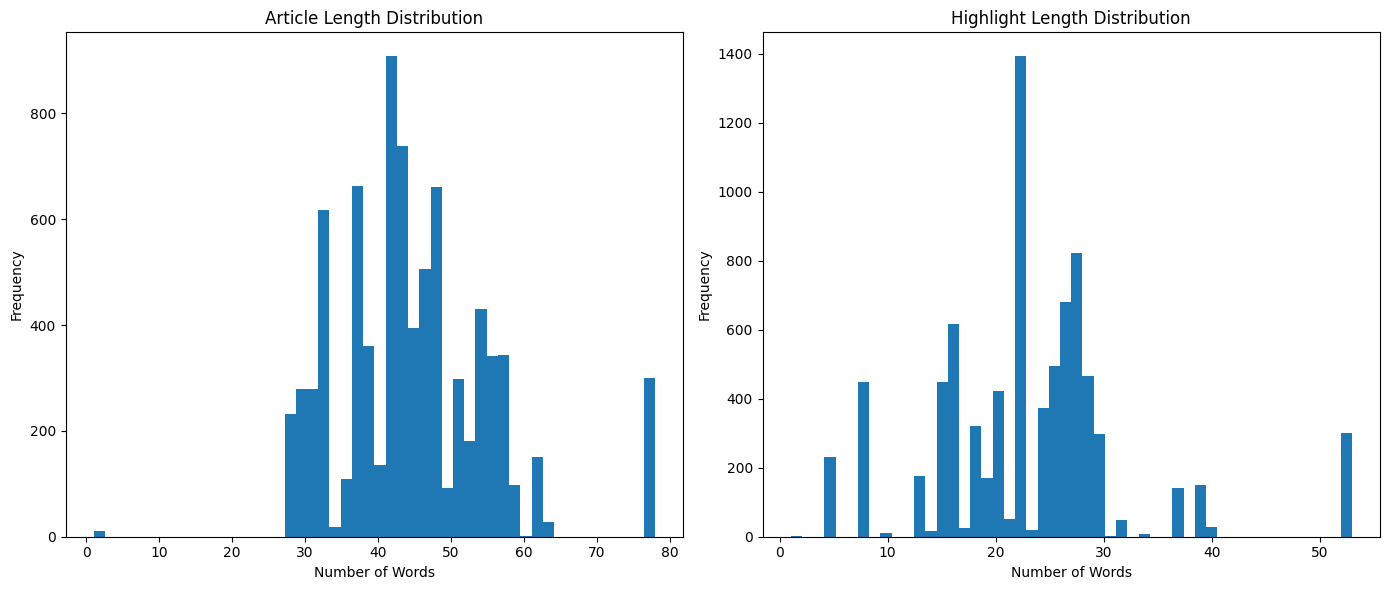

In [6]:
# 2. Data Exploration and Preprocessing
# ------------------------------------

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Basic statistics about article and highlight lengths
df['article_length'] = df['article'].apply(lambda x: len(str(x).split()))
df['highlight_length'] = df['highlights'].apply(lambda x: len(str(x).split()))

print("\nArticle statistics:")
print(f"Average article length: {df['article_length'].mean():.2f} words")
print(f"Max article length: {df['article_length'].max()} words")
print(f"Min article length: {df['article_length'].min()} words")

print("\nHighlight statistics:")
print(f"Average highlight length: {df['highlight_length'].mean():.2f} words")
print(f"Max highlight length: {df['highlight_length'].max()} words")
print(f"Min highlight length: {df['highlight_length'].min()} words")

# Plot distribution of article and highlight lengths
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(df['article_length'], bins=50)
plt.title('Article Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['highlight_length'], bins=50)
plt.title('Highlight Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [7]:
# Preprocessing function
def preprocess_text(text):
    # Handle non-string types
    text = str(text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    return text

# Apply preprocessing
df['article_processed'] = df['article'].apply(preprocess_text)
df['highlights_processed'] = df['highlights'].apply(preprocess_text)

In [8]:
# 3. Data Preparation for BERT
# ---------------------------

# Split the dataset into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
print(f"\nTraining set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# BERT has a maximum input length of 512 tokens
# For text summarization, we'll use an extractive approach:
# 1. Split article into sentences
# 2. Calculate ROUGE score between each sentence and the highlight
# 3. Label sentences with high ROUGE scores as ones to include in summary

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 512

# Download NLTK punkt if not already downloaded
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Initialize rouge scorer
scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)

def get_rouge_scores(sentence, reference):
    try:
        # Handle empty strings or very short texts
        if not sentence or not reference or len(sentence) < 2 or len(reference) < 2:
            return 0
        scores = scorer.score(sentence, reference)
        return scores['rouge1'].fmeasure
    except Exception as e:
        print(f"Error calculating ROUGE: {e}")
        return 0

# Function to split article into sentences and create labels based on ROUGE scores
def create_extractive_samples(article, highlight, threshold=0.3):
    # Handle empty or invalid inputs
    if not article or not highlight:
        return [], []

    sentences = nltk.sent_tokenize(article)

    if len(sentences) <= 1:
        return sentences, [1] * len(sentences)

    # Calculate ROUGE scores for each sentence
    rouge_scores = [get_rouge_scores(sent, highlight) for sent in sentences]

    # Create labels (1 if sentence should be in summary, 0 otherwise)
    # Sentences with ROUGE scores above threshold get labeled as 1
    labels = [1 if score > threshold else 0 for score in rouge_scores]

    # If no sentence is selected, choose the one with the highest score
    if sum(labels) == 0 and rouge_scores:
        max_index = rouge_scores.index(max(rouge_scores))
        labels[max_index] = 1

    return sentences, labels


Training set size: 7358
Validation set size: 818


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
# Define a custom dataset
class DailyMailDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = []
        self.tokenizer = tokenizer
        self.max_len = max_len

        for _, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Processing dataset"):
            try:
                sentences, labels = create_extractive_samples(row['article_processed'], row['highlights_processed'])

                for sentence, label in zip(sentences, labels):
                    encoding = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens=True,
                        max_length=max_len,
                        padding='max_length',
                        truncation=True,
                        return_attention_mask=True,
                        return_tensors='pt'
                    )

                    self.data.append({
                        'article_id': row['id'],
                        'text': sentence,
                        'input_ids': encoding['input_ids'].flatten(),
                        'attention_mask': encoding['attention_mask'].flatten(),
                        'label': torch.tensor(label, dtype=torch.long)
                    })
            except Exception as e:
                print(f"Error processing row: {e}")
                continue

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'article_id': self.data[idx]['article_id'],
            'text': self.data[idx]['text'],
            'input_ids': self.data[idx]['input_ids'],
            'attention_mask': self.data[idx]['attention_mask'],
            'label': self.data[idx]['label']
        }

In [13]:
import nltk
nltk.download('punkt_tab')


# Create datasets (limit to a subset for testing)
# Using fewer samples to prevent memory issues
sample_size = min(1000, len(train_df))
val_size = min(200, len(val_df))

print(f"\nUsing {sample_size} training samples and {val_size} validation samples")

train_subset = train_df.sample(n=sample_size, random_state=42)
val_subset = val_df.sample(n=val_size, random_state=42)

print("\nCreating training dataset...")
train_dataset = DailyMailDataset(train_subset, tokenizer, MAX_LEN)
print("\nCreating validation dataset...")
val_dataset = DailyMailDataset(val_subset, tokenizer, MAX_LEN)

print(f"\nProcessed training samples: {len(train_dataset)}")
print(f"Processed validation samples: {len(val_dataset)}")

# Create DataLoaders
BATCH_SIZE = 16

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE
)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Using 1000 training samples and 200 validation samples

Creating training dataset...


Processing dataset: 100%|██████████| 1000/1000 [00:04<00:00, 231.75it/s]



Creating validation dataset...


Processing dataset: 100%|██████████| 200/200 [00:00<00:00, 316.60it/s]


Processed training samples: 1175
Processed validation samples: 233


In [14]:
# 4. Model Setup
# -------------

# Load pre-trained BERT model for sequence classification (binary)
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,  # Binary classification: include in summary or not
    output_attentions=False,
    output_hidden_states=False
)

model = model.to(device)

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Total number of training steps
total_steps = len(train_dataloader) * 3  # 3 epochs

# Create learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
# 5. Training Function
# ------------------

def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    progress_bar = tqdm(dataloader, desc="Training")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        model.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += len(labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({
            'loss': f'{loss.item():.3f}',
            'accuracy': f'{correct_predictions/total_predictions:.3f}'
        })

    return total_loss / len(dataloader), correct_predictions / total_predictions

In [16]:
# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += len(labels)

    return total_loss / len(dataloader), correct_predictions / total_predictions


In [17]:
# 6. Training Loop
# ---------------

NUM_EPOCHS = 3
history = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print('-' * 20)

    train_loss, train_accuracy = train_epoch(
        model,
        train_dataloader,
        optimizer,
        scheduler,
        device
    )

    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")

    val_loss, val_accuracy = evaluate(model, val_dataloader, device)

    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)



Epoch 1/3
--------------------


Training: 100%|██████████| 74/74 [01:36<00:00,  1.31s/it, loss=0.028, accuracy=0.971]


Train Loss: 0.1093 | Train Accuracy: 0.9711


Evaluating: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


Val Loss: 0.0099 | Val Accuracy: 1.0000

Epoch 2/3
--------------------


Training: 100%|██████████| 74/74 [01:43<00:00,  1.40s/it, loss=0.006, accuracy=0.998]


Train Loss: 0.0123 | Train Accuracy: 0.9983


Evaluating: 100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


Val Loss: 0.0034 | Val Accuracy: 1.0000

Epoch 3/3
--------------------


Training: 100%|██████████| 74/74 [01:43<00:00,  1.40s/it, loss=0.003, accuracy=0.998]


Train Loss: 0.0102 | Train Accuracy: 0.9983


Evaluating: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]

Val Loss: 0.0025 | Val Accuracy: 1.0000



Model saved!


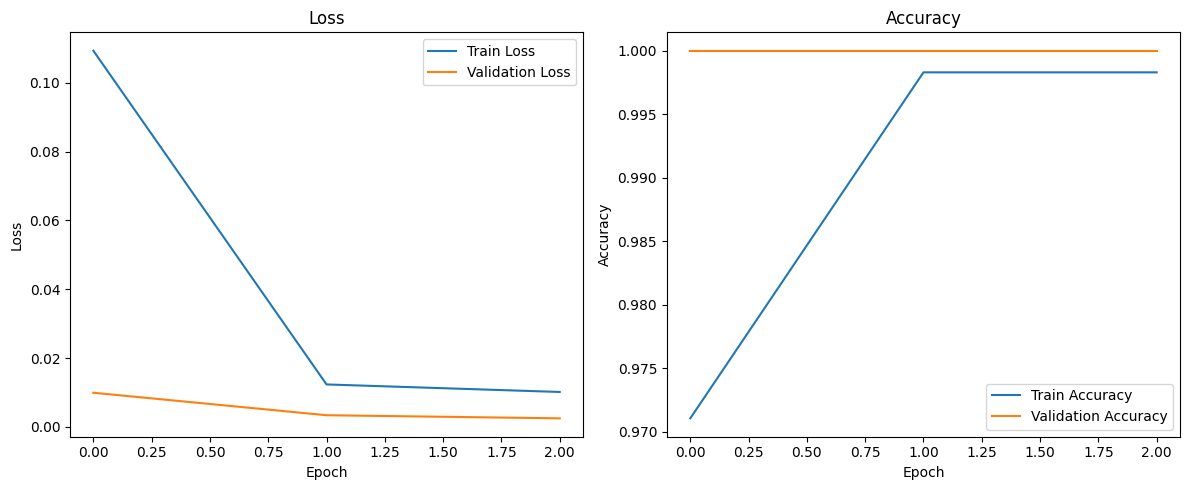

In [18]:
# 7. Save the model
# ---------------

torch.save(model.state_dict(), 'bert_summarizer_model.pt')
print("\nModel saved!")

# Plot training and validation metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [19]:
# 8. Generate summaries with the trained model
# ------------------------------------------

def generate_extractive_summary(article, model, tokenizer, device, max_len=512):
    # Preprocess article
    article = preprocess_text(article)

    # Split into sentences
    sentences = nltk.sent_tokenize(article)

    # Predict which sentences to include in summary
    model.eval()
    selected_sentences = []

    with torch.no_grad():
        for sentence in sentences:
            encoding = tokenizer.encode_plus(
                sentence,
                add_special_tokens=True,
                max_length=max_len,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )

            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            pred = torch.argmax(logits, dim=1).item()

            if pred == 1:
                selected_sentences.append(sentence)

    # If no sentence was selected, select the first one
    if not selected_sentences and sentences:
        selected_sentences.append(sentences[0])

    # Join selected sentences
    summary = ' '.join(selected_sentences)

    return summary


In [20]:
# Test the model on a few examples
test_samples = val_df.head(5)

for i, row in test_samples.iterrows():
    article = row['article']
    original_highlight = row['highlights']

    # Generate summary
    generated_summary = generate_extractive_summary(article, model, tokenizer, device)

    print(f"\nExample {i+1}:")
    print(f"Original article (truncated): {str(article)[:200]}...")
    print(f"Original highlight: {original_highlight}")
    print(f"Generated summary: {generated_summary}")

    # Calculate ROUGE score between generated summary and original highlight
    try:
        score = scorer.score(generated_summary, str(original_highlight))
        print(f"ROUGE-1 F1: {score['rouge1'].fmeasure:.4f}")
        print(f"ROUGE-1 Precision: {score['rouge1'].precision:.4f}")
        print(f"ROUGE-1 Recall: {score['rouge1'].recall:.4f}")
    except Exception as e:
        print(f"Could not calculate ROUGE score: {e}")

    print('-' * 50)


Example 4333:
Original article (truncated): Maya Jama stuns in a semi-sheer cut-out dress after changing out of a silver jumpsuit as she attends two Milan Fashion Week shows and visits third country in 24 hoursMaya Jama is the ultimate jet-sett...
Original highlight: Maya Jama is the ultimate jet-setter at the moment as she hit Milan after spending less than 24 hours in the UK, following her return from South Africa.
Generated summary: maya jama stuns in a semi-sheer cut-out dress after changing out of a silver jumpsuit as she attends two milan fashion week shows and visits third country in 24 hoursmaya jama is the ultimate jet-setter at the moment as she hit milan after spending less than 24 hours in the uk, following her return from south africa.
ROUGE-1 F1: 0.6517
ROUGE-1 Precision: 1.0000
ROUGE-1 Recall: 0.4833
--------------------------------------------------

Example 5697:
Original article (truncated): Jenna Dewan uses a giant bow to cover her baby bump after appearing on Live!